In [99]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import os

class GuitarChordDataset(torch.utils.data.Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, chord, tablature, inTransition, capoPosition = self.data[idx]
        print(filename, chord, tablature, inTransition, capoPosition)
        image = Image.open(os.path.join(self.root_dir, filename))

        # convert to rgb
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        tablature = tablature.replace("X", "99")
        tablature = tablature.split(",")
        tablature = list(map(int, tablature))
        inTransition = int(inTransition)
        return image, tablature, inTransition

In [100]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [101]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('./labeler/labels.db')
cursor = conn.cursor()

# Retrieve the data from the 'labels' table
cursor.execute("SELECT * FROM labels")
sql_data = cursor.fetchall()

# Close the connection
conn.close()

In [102]:
# Create the dataset
data = GuitarChordDataset(sql_data, "image_data/", transform=transform)

# Split the dataset into training, validation, and test sets
val_size = 0.2
test_size = 0.1
train_size = len(data) - (val_size + test_size)

train_size = int((1-val_size-test_size)*len(data))
val_size = int(val_size*len(data))
test_size = len(data) - train_size - val_size

train_data, val_and_test_data = torch.utils.data.random_split(data, [train_size, val_size+test_size])
val_data, test_data = torch.utils.data.random_split(val_and_test_data, [val_size, test_size])

batch_size = 64

# Create data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


capo_0_shape_G_frame_00131.jpg g 3,2,0,0,3,3 0 0
capo_0_shape_G_frame_00131.jpg g 3,2,0,0,3,3 0 0


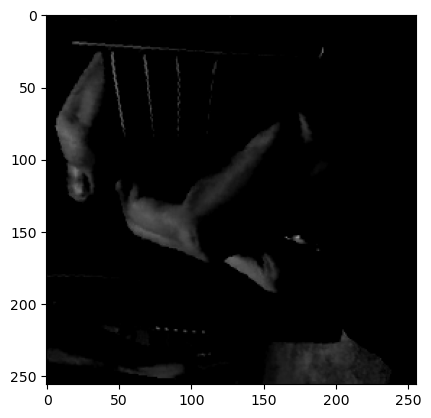

Labels:  [3, 2, 0, 0, 3, 3]


In [106]:
import cv2
import matplotlib.pyplot as plt

# Get a random image and its labels from the train_loader
image = train_loader.dataset[0][0]
label = train_loader.dataset[0][1]

# Use matplotlib to view the image
plt.imshow(image.T)
plt.show()

# Print the labels
print("Labels: ", label)

In [104]:
import torch.nn as nn
import torch.nn.functional as F

class ChordPredictor(nn.Module):
    def __init__(self):
        super(ChordPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 15 * 12, 512)
        self.fc2 = nn.Linear(512, 6)
        self.fc3 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 15 * 12)
        x = F.relu(self.fc1(x))
        tablature = self.fc2(x)
        inTransition = self.sigmoid(self.fc3(x))
        return tablature, inTransition

In [92]:

device = torch.device("mps")
print(device)

model = ChordPredictor().to(device)

mps


In [108]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 10
total_step = len(train_loader)

train_loss_list = []
val_loss_list = []

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        tablature, inTransition = model(inputs)
        loss1 = criterion(tablature, labels[0])
        loss2 = criterion(inTransition, labels[1])
        loss = loss1 + loss2

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute the training loss
        train_loss = loss.item()
        train_loss_list.append(train_loss)

        # if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss1: {:.4f}, Loss2: {:.4f}' 
                .format(epoch+1, num_epochs, i+1, total_step, loss1.item(), loss2.item()))

    # Compute the validation loss
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            tablature, inTransition = model(images)
            loss1 = criterion(tablature, labels[0])
            loss2 = criterion(inTransition, labels[1])
            loss = loss1 + loss2
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/williamcotton/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/williamcotton/miniforge3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'GuitarChordDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 